In [107]:
# -*- coding: utf-8 -*-
'''ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
'''
from __future__ import print_function

import numpy as np
import warnings
import tensorflow

%env KERAS_BACKEND=tensorflow

import keras
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs



def identity_block(input_tensor, kernel_size, filters, stage, block):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
  

    x = Conv2D(filters1, (1, 1))(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same')(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization(axis=bn_axis)(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    filters1, filters2, filters3 = filters
    
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
        
    x = Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization(axis=bn_axis)(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis)(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50(input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):

    # Determine proper input shape
    input_shape = (32,32,3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    block_shape = K.int_shape(x)

    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]),strides=(1, 1))(x)

   
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

def ResNet50_cifar(input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):

    # Determine proper input shape
    input_shape = (32,32,3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(16, (3, 3), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)

    x = conv_block(x, 3, [16, 16, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [16, 16, 64], stage=2, block='b')
    x = identity_block(x, 3, [16, 16, 64], stage=2, block='c')

    x = conv_block(x, 3, [32, 32, 128], stage=3, block='a')
    x = identity_block(x, 3, [32, 32, 128], stage=3, block='b')
    x = identity_block(x, 3, [32, 32, 128], stage=3, block='c')
    x = identity_block(x, 3, [32, 32, 128], stage=3, block='d')

    x = conv_block(x, 3, [64, 64, 256], stage=4, block='a')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='c')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='d')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='e')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='f')

    x = conv_block(x, 3, [128, 128, 512], stage=5, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=5, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=5, block='c')
    
    block_shape = K.int_shape(x)

    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]),strides=(1, 1))(x)

   
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model

def ResNet50_cifar_small(input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):

    # Determine proper input shape
    input_shape = (32,32,3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((1, 1))(img_input)
    x = Conv2D(16, (3, 3), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    block_shape = K.int_shape(x)
    print(block_shape)
    x = conv_block(x, 3, [16, 16, 64], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [16, 16, 64], stage=2, block='b')
    x = identity_block(x, 3, [16, 16, 64], stage=2, block='c')
    block_shape = K.int_shape(x)
    print(block_shape)
    x = conv_block(x, 3, [32, 32, 128], stage=3, block='a')
    x = identity_block(x, 3, [32, 32, 128], stage=3, block='b')
    x = identity_block(x, 3, [32, 32, 128], stage=3, block='c')
    block_shape = K.int_shape(x)
    print(block_shape)
    x = conv_block(x, 3, [64, 64, 256], stage=4, block='a')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=4, block='c')
    
    
    block_shape = K.int_shape(x)
    print()

    x = AveragePooling2D(pool_size=(block_shape[1], block_shape[2]),strides=(1, 1))(x)

   
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)


    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    return model



   

env: KERAS_BACKEND=tensorflow


In [108]:
 keras.backend.backend()

'tensorflow'

In [51]:
 model = ResNet50(classes = 10)


In [52]:
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [109]:
from keras.datasets import cifar10


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train/255
x_test = x_test/255 

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [110]:
import keras

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [29]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=128),
                        steps_per_epoch=x_train.shape[0] // 128,
                        epochs=100,
                        validation_data=(x_test, y_test))

Epoch 1/100
390/390 [==============================] - 60s - loss: 2.4729 - acc: 0.2055 - val_loss: 2.2552 - val_acc: 0.1932
Epoch 2/100
390/390 [==============================] - 49s - loss: 1.8500 - acc: 0.3340 - val_loss: 2.1240 - val_acc: 0.3474
Epoch 3/100
390/390 [==============================] - 49s - loss: 1.5394 - acc: 0.4431 - val_loss: 1.5906 - val_acc: 0.4459
Epoch 4/100
390/390 [==============================] - 49s - loss: 1.3877 - acc: 0.4984 - val_loss: 1.3233 - val_acc: 0.5320
Epoch 5/100
390/390 [==============================] - 49s - loss: 1.2775 - acc: 0.5422 - val_loss: 1.3034 - val_acc: 0.5491
Epoch 6/100
390/390 [==============================] - 49s - loss: 1.1913 - acc: 0.5759 - val_loss: 1.6572 - val_acc: 0.4607
Epoch 7/100
390/390 [==============================] - 49s - loss: 1.1166 - acc: 0.6019 - val_loss: 1.1349 - val_acc: 0.6028
Epoch 8/100
390/390 [==============================] - 49s - loss: 1.0496 - acc: 0.6270 - val_loss: 1.0502 - val_acc: 0.6298


390/390 [==============================] - 49s - loss: 0.2021 - acc: 0.9289 - val_loss: 0.9889 - val_acc: 0.7786
Epoch 67/100
390/390 [==============================] - 49s - loss: 0.2025 - acc: 0.9295 - val_loss: 0.8573 - val_acc: 0.7782
Epoch 68/100
390/390 [==============================] - 49s - loss: 0.1933 - acc: 0.9307 - val_loss: 0.9279 - val_acc: 0.7858
Epoch 69/100
390/390 [==============================] - 49s - loss: 0.1931 - acc: 0.9337 - val_loss: 1.1510 - val_acc: 0.7429
Epoch 70/100
390/390 [==============================] - 49s - loss: 0.1925 - acc: 0.9328 - val_loss: 0.9661 - val_acc: 0.7652
Epoch 71/100
390/390 [==============================] - 49s - loss: 0.1825 - acc: 0.9374 - val_loss: 1.0358 - val_acc: 0.7599
Epoch 72/100
390/390 [==============================] - 49s - loss: 0.1830 - acc: 0.9369 - val_loss: 0.9303 - val_acc: 0.7828
Epoch 73/100
390/390 [==============================] - 49s - loss: 0.1796 - acc: 0.9377 - val_loss: 0.9865 - val_acc: 0.7766
Epoch

In [55]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=128),
                        steps_per_epoch=x_train.shape[0] // 128,
                        epochs=100,
                        validation_data=(x_test, y_test))

Epoch 1/100
390/390 [==============================] - 67s - loss: 2.4457 - acc: 0.1961 - val_loss: 2.7546 - val_acc: 0.1068
Epoch 2/100
390/390 [==============================] - 54s - loss: 1.9445 - acc: 0.2921 - val_loss: 1.8007 - val_acc: 0.3531
Epoch 3/100
390/390 [==============================] - 53s - loss: 1.7740 - acc: 0.3539 - val_loss: 1.7901 - val_acc: 0.3819
Epoch 4/100
390/390 [==============================] - 53s - loss: 1.6720 - acc: 0.3930 - val_loss: 1.6148 - val_acc: 0.4188
Epoch 5/100
390/390 [==============================] - 53s - loss: 1.5971 - acc: 0.4197 - val_loss: 1.5636 - val_acc: 0.4463
Epoch 6/100
390/390 [==============================] - 54s - loss: 1.5334 - acc: 0.4414 - val_loss: 1.4703 - val_acc: 0.4757
Epoch 7/100
390/390 [==============================] - 54s - loss: 1.4686 - acc: 0.4663 - val_loss: 1.4617 - val_acc: 0.4822
Epoch 8/100
390/390 [==============================] - 54s - loss: 1.4139 - acc: 0.4910 - val_loss: 1.4032 - val_acc: 0.4982


390/390 [==============================] - 53s - loss: 0.2559 - acc: 0.9097 - val_loss: 0.9228 - val_acc: 0.7555
Epoch 67/100
390/390 [==============================] - 53s - loss: 0.3466 - acc: 0.8830 - val_loss: 0.8335 - val_acc: 0.7645
Epoch 68/100
390/390 [==============================] - 53s - loss: 0.2520 - acc: 0.9104 - val_loss: 0.9002 - val_acc: 0.7574
Epoch 69/100
390/390 [==============================] - 53s - loss: 0.2251 - acc: 0.9196 - val_loss: 0.9178 - val_acc: 0.7522
Epoch 70/100
390/390 [==============================] - 53s - loss: 0.2082 - acc: 0.9258 - val_loss: 0.9025 - val_acc: 0.7628
Epoch 71/100
390/390 [==============================] - 54s - loss: 0.2001 - acc: 0.9292 - val_loss: 0.9685 - val_acc: 0.7516
Epoch 72/100
390/390 [==============================] - 53s - loss: 0.2045 - acc: 0.9284 - val_loss: 0.9560 - val_acc: 0.7544
Epoch 73/100
390/390 [==============================] - 53s - loss: 0.1936 - acc: 0.9313 - val_loss: 1.0225 - val_acc: 0.7398
Epoch

In [74]:
 model1 = ResNet50_cifar(classes = 10)

In [85]:
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [86]:
from keras.datasets import cifar10


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train/255
x_test = x_test/255 

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [87]:
import keras

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [78]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model1.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=128),
                        steps_per_epoch=x_train.shape[0] // 128,
                        epochs=100,
                        validation_data=(x_test, y_test))

Epoch 1/100
390/390 [==============================] - 61s - loss: 2.2006 - acc: 0.2005 - val_loss: 3.2887 - val_acc: 0.1007
Epoch 2/100
390/390 [==============================] - 45s - loss: 1.9569 - acc: 0.2781 - val_loss: 1.8985 - val_acc: 0.3102
Epoch 3/100
390/390 [==============================] - 45s - loss: 1.8469 - acc: 0.3203 - val_loss: 1.8144 - val_acc: 0.3418
Epoch 4/100
390/390 [==============================] - 45s - loss: 1.7609 - acc: 0.3567 - val_loss: 1.7162 - val_acc: 0.3865
Epoch 5/100
390/390 [==============================] - 45s - loss: 1.6951 - acc: 0.3809 - val_loss: 1.6371 - val_acc: 0.4061
Epoch 6/100
390/390 [==============================] - 45s - loss: 1.6339 - acc: 0.4070 - val_loss: 1.5792 - val_acc: 0.4297
Epoch 7/100
390/390 [==============================] - 45s - loss: 1.5896 - acc: 0.4236 - val_loss: 1.5100 - val_acc: 0.4506
Epoch 8/100
390/390 [==============================] - 45s - loss: 1.5443 - acc: 0.4388 - val_loss: 1.4871 - val_acc: 0.4567


390/390 [==============================] - 45s - loss: 0.5672 - acc: 0.7968 - val_loss: 1.0066 - val_acc: 0.6814
Epoch 67/100
390/390 [==============================] - 45s - loss: 0.5605 - acc: 0.7988 - val_loss: 1.0743 - val_acc: 0.6642
Epoch 68/100
390/390 [==============================] - 45s - loss: 0.5501 - acc: 0.8030 - val_loss: 1.1000 - val_acc: 0.6573
Epoch 69/100
390/390 [==============================] - 45s - loss: 0.5372 - acc: 0.8070 - val_loss: 1.0653 - val_acc: 0.6702
Epoch 70/100
390/390 [==============================] - 45s - loss: 0.5329 - acc: 0.8092 - val_loss: 1.0237 - val_acc: 0.6752
Epoch 71/100
390/390 [==============================] - 45s - loss: 0.5315 - acc: 0.8116 - val_loss: 1.0731 - val_acc: 0.6663
Epoch 72/100
390/390 [==============================] - 45s - loss: 0.5184 - acc: 0.8135 - val_loss: 1.0523 - val_acc: 0.6697
Epoch 73/100
390/390 [==============================] - 45s - loss: 0.5094 - acc: 0.8184 - val_loss: 1.0174 - val_acc: 0.6773
Epoch

In [84]:
 model2 = ResNet50_cifar_small(classes = 10)

(None, 16, 16, 16)
(None, 16, 16, 64)
(None, 8, 8, 128)



In [89]:
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [90]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model2.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=128),
                        steps_per_epoch=x_train.shape[0] // 128,
                        epochs=100,
                        validation_data=(x_test, y_test))

Epoch 1/100
390/390 [==============================] - 46s - loss: 2.0845 - acc: 0.2424 - val_loss: 2.5170 - val_acc: 0.1538
Epoch 2/100
390/390 [==============================] - 38s - loss: 1.7754 - acc: 0.3465 - val_loss: 1.6713 - val_acc: 0.3895
Epoch 3/100
390/390 [==============================] - 38s - loss: 1.6571 - acc: 0.3914 - val_loss: 1.5829 - val_acc: 0.4223
Epoch 4/100
390/390 [==============================] - 38s - loss: 1.5869 - acc: 0.4173 - val_loss: 1.5334 - val_acc: 0.4355
Epoch 5/100
390/390 [==============================] - 38s - loss: 1.5285 - acc: 0.4401 - val_loss: 1.4574 - val_acc: 0.4640
Epoch 6/100
390/390 [==============================] - 38s - loss: 1.4804 - acc: 0.4571 - val_loss: 1.4258 - val_acc: 0.4759
Epoch 7/100
390/390 [==============================] - 38s - loss: 1.4397 - acc: 0.4733 - val_loss: 1.3816 - val_acc: 0.4932
Epoch 8/100
390/390 [==============================] - 38s - loss: 1.4026 - acc: 0.4878 - val_loss: 1.3560 - val_acc: 0.5055


390/390 [==============================] - 37s - loss: 0.6944 - acc: 0.7512 - val_loss: 0.8179 - val_acc: 0.7175
Epoch 67/100
390/390 [==============================] - 37s - loss: 0.6848 - acc: 0.7559 - val_loss: 0.8091 - val_acc: 0.7185
Epoch 68/100
390/390 [==============================] - 38s - loss: 0.6880 - acc: 0.7573 - val_loss: 0.7986 - val_acc: 0.7234
Epoch 69/100
390/390 [==============================] - 38s - loss: 0.6772 - acc: 0.7586 - val_loss: 0.8018 - val_acc: 0.7225
Epoch 70/100
390/390 [==============================] - 38s - loss: 0.6675 - acc: 0.7642 - val_loss: 0.7934 - val_acc: 0.7264
Epoch 71/100
390/390 [==============================] - 38s - loss: 0.6651 - acc: 0.7650 - val_loss: 0.8207 - val_acc: 0.7176
Epoch 72/100
390/390 [==============================] - 38s - loss: 0.6623 - acc: 0.7631 - val_loss: 0.8030 - val_acc: 0.7206
Epoch 73/100
390/390 [==============================] - 38s - loss: 0.6589 - acc: 0.7660 - val_loss: 0.7935 - val_acc: 0.7232
Epoch

In [111]:
 model2 = ResNet50_cifar_small(classes = 10)

(None, 16, 16, 16)
(None, 16, 16, 64)
(None, 8, 8, 128)



In [112]:
model2.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [113]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
histori = model2.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=128),
                        steps_per_epoch=x_train.shape[0] // 128,
                        epochs=70,
                        validation_data=(x_test, y_test))

Epoch 1/70
390/390 [==============================] - 54s - loss: 1.6663 - acc: 0.3808 - val_loss: 2.3174 - val_acc: 0.2637
Epoch 2/70
390/390 [==============================] - 39s - loss: 1.3447 - acc: 0.5119 - val_loss: 1.5011 - val_acc: 0.4614
Epoch 3/70
390/390 [==============================] - 39s - loss: 1.1906 - acc: 0.5705 - val_loss: 1.3068 - val_acc: 0.5478
Epoch 4/70
390/390 [==============================] - 39s - loss: 1.0834 - acc: 0.6123 - val_loss: 1.1053 - val_acc: 0.6077
Epoch 5/70
390/390 [==============================] - 39s - loss: 1.0007 - acc: 0.6418 - val_loss: 1.0135 - val_acc: 0.6369
Epoch 6/70
390/390 [==============================] - 39s - loss: 0.9238 - acc: 0.6699 - val_loss: 1.0549 - val_acc: 0.6301
Epoch 7/70
390/390 [==============================] - 39s - loss: 0.8693 - acc: 0.6923 - val_loss: 1.0320 - val_acc: 0.6481
Epoch 8/70
390/390 [==============================] - 39s - loss: 0.8160 - acc: 0.7112 - val_loss: 1.0217 - val_acc: 0.6535
Epoch 9/

390/390 [==============================] - 39s - loss: 0.2529 - acc: 0.9099 - val_loss: 0.5266 - val_acc: 0.8359
Epoch 67/70
390/390 [==============================] - 39s - loss: 0.2464 - acc: 0.9109 - val_loss: 0.5899 - val_acc: 0.8255
Epoch 68/70
390/390 [==============================] - 39s - loss: 0.2492 - acc: 0.9092 - val_loss: 0.5301 - val_acc: 0.8367
Epoch 69/70
390/390 [==============================] - 39s - loss: 0.2458 - acc: 0.9120 - val_loss: 0.4951 - val_acc: 0.8483
Epoch 70/70
390/390 [==============================] - 39s - loss: 0.2436 - acc: 0.9139 - val_loss: 0.5853 - val_acc: 0.8294


In [114]:
histori


In [115]:
print(histori.history.keys())


dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


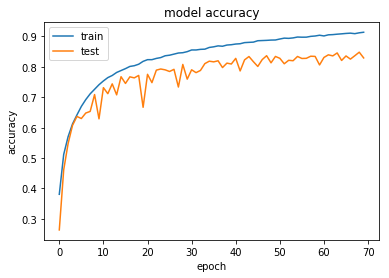

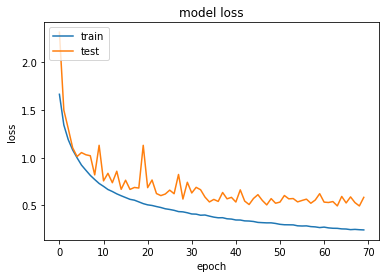

In [116]:
import matplotlib.pyplot as plt

plt.plot(histori.history['acc'])
plt.plot(histori.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histori.history['loss'])
plt.plot(histori.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()